In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
INIT_LR = 1e-4
EPOCHS = 5
BS = 73

DIRECTORY = r"D:\users\meyyappan\downloads\Face Mask Dataset"
CATEGORIES = ["withmask", "withoutmask"]

In [3]:
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


[INFO] loading images...


In [4]:

data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)



In [5]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [7]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
# removing the top layer of the base model
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# creating the head of the model 
head_Model = baseModel.output
head_Model = MaxPooling2D(pool_size = (2, 2)) (head_Model)
head_Model = Conv2D(32,(2,2),activation='relu') (head_Model)
head_Model = AveragePooling2D(pool_size=(2, 2))(head_Model)
head_Model = Flatten(name="flatten")(head_Model)
head_Model = Dense(128, activation="relu")(head_Model)
head_Model = Dropout(0.5)(head_Model)
head_Model = Dense(2, activation="softmax")(head_Model)

In [8]:
# placing the head  model on top of the base model 
model = Model(inputs=baseModel.input, outputs=head_Model)
#looping over all layers to freeze the model
for layer in baseModel.layers:
    layer.trainable = False
# compiling the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
      metrics=["accuracy"])

[INFO] compiling model...


D:\anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [9]:
 # trainning the model
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/5
129/129 [==============================] - 263s 2s/step - loss: 0.2426 - accuracy: 0.9264 - val_loss: 0.0429 - val_accuracy: 0.9864
Epoch 2/5
129/129 [==============================] - 263s 2s/step - loss: 0.0776 - accuracy: 0.9803 - val_loss: 0.0327 - val_accuracy: 0.9877
Epoch 3/5
129/129 [==============================] - 280s 2s/step - loss: 0.0583 - accuracy: 0.9844 - val_loss: 0.0276 - val_accuracy: 0.9903
Epoch 4/5
129/129 [==============================] - 284s 2s/step - loss: 0.0438 - accuracy: 0.9872 - val_loss: 0.0269 - val_accuracy: 0.9898
Epoch 5/5
129/129 [==============================] - 278s 2s/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.0221 - val_accuracy: 0.9928


In [10]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each and every image in the testing set, we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# printing the classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
     target_names=lb.classes_))

# saving the model
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

    withmask       1.00      0.99      0.99      1177
 withoutmask       0.99      1.00      0.99      1182

    accuracy                           0.99      2359
   macro avg       0.99      0.99      0.99      2359
weighted avg       0.99      0.99      0.99      2359

[INFO] saving mask detector model...


D:\anaconda\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


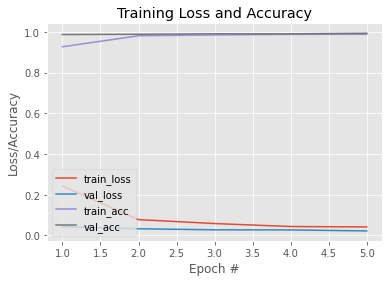

In [11]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, N+1), H.history["loss"], label="train_loss")
plt.plot(np.arange(1, N+1), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, N+1), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

This image doesn't contain mask!!!


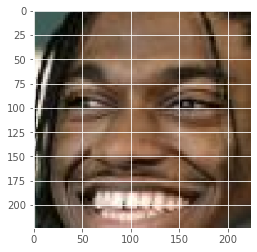

In [12]:
img12 =load_img(r'D:\users\meyyappan\downloads\Face Mask Dataset\withoutmask\5.png',target_size=(224,224))
plt.imshow(img12)
img12 = img_to_array(img12)
img12 = img12/255.0
img12 = np.expand_dims(img12,axis=0)
pred1 = np.argmax(model.predict(img12),axis=1)
if pred1[0] == 0:
    print("This image contains mask!!!")
else:
    print("This image doesn't contain mask!!!")